# Постановка задачи
Создать прототип RAG-агента для помощи исследователям в поиске новых потенциальных мишеней для разработки лекарств от болезни Альцгеймера.
# Задачи
**Часть 1. Подготовка данных**
- Собрать ~10–100 научных статей из открытых источников (PubMed, bioRxiv) по темам:
  - Alzheimer's disease targets
  - Alzheimer therapeutic targets
  - Alzheimer drug targets
- Извлечь и очистить текст (абстракты + введение + заключение)
- Провести эксплораторный анализ текстов статей
- Подготовить данные для моделирования

**Часть 2. Реализация RAG системы**
- Построить pipeline для retrieval + generation
- Выбрать метрики и оценить качество работы подхода
- Сделать вывод

**Часть 3. Интерфейс**
- Реализовать простой интерфейс на Streamlit

Обязательные поля:
- Ввод запроса исследователя
- Отображение найденных источников
- Сгенерированный ответ с указанием источников

**Часть 4. Вопросы**
- На какие модальности данных можно расширить решение?
- Как это можно сделать?
- Какие модели и почему вы выбрали для решения


# Подготовка данных

In [1]:
import os
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
os.getcwd()

'E:\\учеба\\biocad_test\\jupyter'

In [4]:
files = os.listdir('../data/')
files

['molecules-27-04124.pdf',
 'nihms-303633.pdf',
 'nihms-594059.pdf',
 'nihms-1991779.pdf',
 '11033_2021_Article_6512.pdf',
 '13195_2024_Article_1504.pdf',
 '13311_2020_Article_954.pdf',
 'ad-16-4-1987.pdf',
 'biomolecules-11-00600.pdf',
 'cddis201157a.pdf',
 'cells-13-01426.pdf',
 'ijms-24-00778.pdf',
 'ijms-24-05383.pdf',
 'jnnp-2023-331142.pdf',
 'JTCM-45-4-922.pdf']

для начала я попробую подготовить и проанализировать 1 статью, затем напишу код для подготовки сразу всех статей

In [5]:
loader = PyMuPDFLoader('../data/' + files[0])
pages = loader.load()

In [6]:
len(pages)

19

In [7]:
pages[0].page_content

'Citation: Althafar, Z.M. Targeting\nMicroglia in Alzheimer’s Disease:\nFrom Molecular Mechanisms to\nPotential Therapeutic Targets for\nSmall Molecules. Molecules 2022, 27,\n4124. https://doi.org/10.3390/\nmolecules27134124\nAcademic Editor: Diego\nMuñoz-Torrero\nReceived: 9 June 2022\nAccepted: 23 June 2022\nPublished: 27 June 2022\nPublisher’s Note: MDPI stays neutral\nwith regard to jurisdictional claims in\npublished maps and institutional afﬁl-\niations.\nCopyright:\n© 2022 by the author.\nLicensee MDPI, Basel, Switzerland.\nThis article is an open access article\ndistributed\nunder\nthe\nterms\nand\nconditions of the Creative Commons\nAttribution (CC BY) license (https://\ncreativecommons.org/licenses/by/\n4.0/).\nmolecules\nReview\nTargeting Microglia in Alzheimer’s Disease: From Molecular\nMechanisms to Potential Therapeutic Targets for Small Molecules\nZiyad M. Althafar\nDepartment of Medical Laboratories Sciences, College of Applied Medical Sciences in Alquwayiyah,\nShaqra U

In [8]:
full_text = ' '.join(page.page_content for page in pages)

In [9]:
# full_text

## Извлечение (абстракты + введение + заключение)

In [10]:
abstract_match = re.search(r'(?i)abstract[:\s]*(.*?)(?=\s*(?:Keywords|1\.\s+Introduction|Introduction))', full_text, re.DOTALL)
abstract = abstract_match.group(1).strip() if abstract_match else ""

In [11]:
abstract

'Alzheimer’s disease (AD) is a common, progressive, and devastating neurodegenerative\ndisorder that mainly affects the elderly. Microglial dysregulation, amyloid-beta (Aβ) plaques, and\nintracellular neuroﬁbrillary tangles play crucial roles in the pathogenesis of AD. In the brain, mi-\ncroglia play roles as immune cells to provide protection against virus injuries and diseases. They\nhave signiﬁcant contributions in the development of the brain, cognition, homeostasis of the brain,\nand plasticity. Multiple studies have conﬁrmed that uncontrolled microglial function can result in\nimpaired microglial mitophagy, induced Aβ accumulation and tau pathology, and a chronic neuroin-\nﬂammatory environment. In the brain, most of the genes that are associated with AD risk are highly\nexpressed by microglia. Although it was initially regarded that microglia reaction is incidental and\ninduced by dystrophic neurites and Aβ plaques. Nonetheless, it has been reported by genome-wide\nassociation s

In [12]:
intro_match = re.search(r'(?i)(?:1\.\s+)?Introduction[:\s]*(.*?)(?=\s*2\.\s+)', full_text, re.DOTALL)
introduction = intro_match.group(1).strip() if intro_match else ""

In [13]:
introduction

'Alzheimer’s disease (AD) is a complex neurodegenerative disease (ND) and the char-\nacteristics of AD include cognitive deﬁcit and memory loss that can eventually disrupt the\nmotor system, visuospatial orientation, speech, and behavior [1,2]. Several neuropathologi-\ncal hallmarks of AD including inﬂammation, intracellular neuroﬁbrillary tangles (NFTs),\nand extracellular Aβ deposits have already been well identiﬁed [3–5]. Tau proteins and\ndeposits of Aβ peptides are detected in different brain areas, which can further lead to\nmicroglial activation, mitochondrial dysfunction, synaptic dysfunction, and even neuronal\ncell death [6,7]. Characteristics of AD-related inﬂammation include reactive microglia\naround Aβ plaques, which preserve an inﬂammatory state via releasing various proinﬂam-\nmatory mediators, which can ultimately lead to neuronal loss. In the case of AD, reactive\ngliosis histology indicates the aberrant morphology and proliferation of microglia and as-\ntrocytes. It 

In [14]:
concl_match = re.search(r'(?i)(?:[0-9]\.\s+)?Conclusions?[\s\w]*(.*?)(?=\s*(?:Funding|References|Acknowledgments|Author Contributions))', full_text, re.DOTALL)
conclusions = concl_match.group(1).strip() if concl_match else ""

In [15]:
conclusions

', instead of\ntargeting the underlying mechanisms associated with AD. Therefore, there is a strong need\nfor treatment options that can interact with the mechanisms of AD pathogenesis and slow\ndown its advancement. Neuroinﬂammation is one such downstream target, which is a\ncause instead of a consequence of neurodegeneration. Mechanisms that are linked with AD\npathogenesis are highly complex and microglia are the key neuroinﬂammation modulators.\nIn addition, microglia have a signiﬁcant contribution in triggering synaptic dysfunction and\nloss; however, the precise and exact mechanisms are yet to be fully revealed. Thus, better\nknowledge regarding the molecular and cellular mechanisms of the microglia–synapse\ninteraction is required on an urgent basis for the development of novel anti-AD therapies.\nMoreover, more studies are required regarding whether or not the prevention of microglia-\nmediated removal of synapses decreases cognitive deﬁcits and averts neurodegeneration.'

получилось))

In [16]:
final_text = f"ABSTRACT:\n{abstract}\n\nINTRODUCTION:\n{introduction}\n\nCONCLUSIONS:\n{conclusions}"

## Очистка

In [17]:
# убираем эскейп последовательности и символы unicode 
sample_text = final_text.replace('-\n', '')
sample_text = sample_text.replace('\n', ' ')
sample_text = sample_text.replace('\xad', '')
sample_text = sample_text.replace('\t', '')
sample_text = sample_text.replace('\u2002', '')
sample_text = sample_text.replace('\u200d', '')
sample_text = sample_text.replace('\u200b', '')
sample_text = sample_text.replace('\u2009', '')
sample_text = sample_text.replace('\u2003', '')
sample_text = sample_text.replace('\x01', '')
sample_text = sample_text.replace('\x02', '')
sample_text = sample_text.replace('\x03', '')
sample_text = sample_text.replace('\x04', '')
sample_text = sample_text.replace('\x05', '')
sample_text = sample_text.replace('\x06', '')
sample_text = sample_text.replace('\x07', '')
sample_text = sample_text.replace('\x08', '')

# убираем ссылки в квадратных скобках
sample_text = re.sub(r'\[.*?\]', '', sample_text)
# sample_text = sample_text.encode('ascii', errors='ignore').decode() # это нельзя исользовать из-за грческих символов

sample_text

'ABSTRACT: Alzheimer’s disease (AD) is a common, progressive, and devastating neurodegenerative disorder that mainly affects the elderly. Microglial dysregulation, amyloid-beta (Aβ) plaques, and intracellular neuroﬁbrillary tangles play crucial roles in the pathogenesis of AD. In the brain, microglia play roles as immune cells to provide protection against virus injuries and diseases. They have signiﬁcant contributions in the development of the brain, cognition, homeostasis of the brain, and plasticity. Multiple studies have conﬁrmed that uncontrolled microglial function can result in impaired microglial mitophagy, induced Aβ accumulation and tau pathology, and a chronic neuroinﬂammatory environment. In the brain, most of the genes that are associated with AD risk are highly expressed by microglia. Although it was initially regarded that microglia reaction is incidental and induced by dystrophic neurites and Aβ plaques. Nonetheless, it has been reported by genome-wide association studi

## Анализ сущностей

In [18]:
doc = nlp(sample_text)

In [19]:
entities = [(ent.text, ent.label_) for ent in doc.ents]
print(f'Топ 10 сущностей:\n {entities[:10]}')

Топ 10 сущностей:
 [('Aβ', 'PERSON'), ('Aβ', 'PERSON'), ('early AD', 'DATE'), ('ND', 'ORG'), ('Aβ', 'PERSON'), ('Aβ', 'PERSON'), ('1', 'CARDINAL'), ('Microglia', 'PERSON'), ('CNS', 'ORG'), ('Molecules 2022', 'PERSON')]


In [20]:
words = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
words_freq = Counter(words).most_common(20)
words_freq_df = pd.DataFrame(words_freq, columns=['Words', 'Freq'])

Text(0.5, 1.0, 'Top 20 most frequent words')

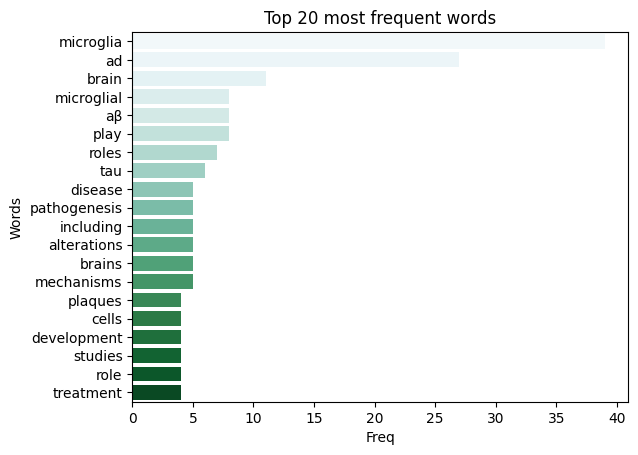

In [21]:
sns.barplot(data=words_freq_df, x='Freq', y='Words', palette='BuGn', hue='Words', legend=False)
plt.title('Top 20 most frequent words')

## Чанкинг

In [22]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150, separators=["\n\n", "\n", ". ", " ", ""])
chunks = splitter.split_text(sample_text)

In [23]:
len(chunks)

10

In [24]:
chunks[0]

'ABSTRACT: Alzheimer’s disease (AD) is a common, progressive, and devastating neurodegenerative disorder that mainly affects the elderly. Microglial dysregulation, amyloid-beta (Aβ) plaques, and intracellular neuroﬁbrillary tangles play crucial roles in the pathogenesis of AD. In the brain, microglia play roles as immune cells to provide protection against virus injuries and diseases. They have signiﬁcant contributions in the development of the brain, cognition, homeostasis of the brain, and plasticity. Multiple studies have conﬁrmed that uncontrolled microglial function can result in impaired microglial mitophagy, induced Aβ accumulation and tau pathology, and a chronic neuroinﬂammatory environment. In the brain, most of the genes that are associated with AD risk are highly expressed by microglia. Although it was initially regarded that microglia reaction is incidental and induced by dystrophic neurites and Aβ plaques'

## Класс для подготовки данных

In [25]:
from langchain_core.documents import Document
from typing import List

In [26]:
class AlzheimerDataProcessor:
    def __init__(self, data_path: str):
        self.data_path = data_path
        self.raw_docs = []
        self.clean_docs = []
        self.chunks = []
        self.nlp = spacy.load("en_core_web_sm")

    def extract_chapters(self, text):
        """Функция для извлеченения абстракта, введения и заключения из пдф-файла"""
        abstract_match = re.search(r'(?i)abstract[:\s]*(.*?)(?=\s*(?:Keywords|Key words|1\.\s+Introduction|Introduction))', full_text, re.DOTALL)
        abstract = abstract_match.group(1).strip() if abstract_match else ""

        intro_match = re.search(r'(?i)(?:1\.\s+)?Introduction[:\s]*(.*?)(?=\s*2\.\s+)', full_text, re.DOTALL)
        introduction = intro_match.group(1).strip() if intro_match else ""

        concl_match = re.search(r'(?i)(?:[0-9]\.\s+)?Conclusions?[\s\w]*(.*?)(?=\s*(?:Funding|References|Acknowledgments|Author Contributions))', full_text, re.DOTALL)
        conclusions = concl_match.group(1).strip() if concl_match else ""

        final_text = f"ABSTRACT:\n{abstract}\n\nINTRODUCTION:\n{introduction}\n\nCONCLUSIONS:\n{conclusions}"

        return final_text

    def load_pdf_files(self):
        """Функция для загрузки исходных пдф-файлов"""
        files = [f for f in os.listdir(self.data_path) if f.endswith('.pdf')]
        docs = []
        
        for file in files:
            loader = PyMuPDFLoader(os.path.join(self.data_path, file))
            pages = loader.load()
            text = '\n'.join([page.page_content for page in pages])
            extracted_text = self.extract_chapters(text)
            metadata = pages[0].metadata
            metadata['source'] = file

            docs.append(Document(page_content=extracted_text, metadata=metadata))
            
        self.raw_docs = docs
        
    def make_text_clean(self, text:str) -> str:
        """Фукция для очистки текста"""
        clean_text = text.replace('\n', '')
        clean_text = clean_text.replace('-\n', '')
        clean_text = clean_text.replace('\t', '')
        clean_text = re.sub(r'[\x00-\x1F\x7F-\x9F\u200b-\u200d\u2002-\u2009\u2003\xad]', '', clean_text)
        
        # убираем ссылки в квадратных скобках и авторов
        clean_text = re.sub(r'\[\d+(?:[\s\-,]\s*\d+)*\]', '', clean_text) 
        clean_text = re.sub(r'\([A-Za-z]+ et al\., \d{4}\)', '', clean_text)
    
        # удаляем лишних пробелов
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        
        return clean_text

    def process_and_clean(self):
        """Функция для обработки всех документов"""
        self.clean_docs = []
        for doc in self.raw_docs:
            clean_text = self.make_text_clean(doc.page_content)
            clean_doc = Document(page_content=clean_text, metadata=doc.metadata)
            self.clean_docs.append(clean_doc)

    def run_eda(self):
        """Функция для проведения разведочного анализа"""
        all_text = ''.join([doc.page_content for doc in self.clean_docs])
        # ограничиваем текст для spacy, если он слишком большой
        all_text_nlp = self.nlp(all_text[:1000000])
        
        words = [token.text.lower() for token in all_text_nlp if not token.is_stop and not token.is_punct and token.is_alpha]
        words_freq = Counter(words).most_common(20)
        words_freq_df = pd.DataFrame(words_freq, columns=['Words', 'Freq']) 
    
        plt.figure(figsize=(10, 6))
        sns.barplot(data=words_freq_df, x='Freq', y='Words', palette='BuGn', hue='Words', legend=False)
        plt.title('Top 20 most frequent words')
        plt.show()

        entities = [(ent.text, ent.label_) for ent in doc.ents]
        print('Top 10 found entities:')
        print(entities[:10])

        return words_freq_df
        
    def prepare_chunks(self):
        """Функция для подготовки чанков для RAG"""
        splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150, separators=["\n\n", "\n", ". ", " ", ""])
        self.chunks = splitter.split_documents(self.clean_docs)
        return self.chunks

In [27]:
processor = AlzheimerDataProcessor('../data/')

In [28]:
processor.load_pdf_files()

In [29]:
processor.process_and_clean()

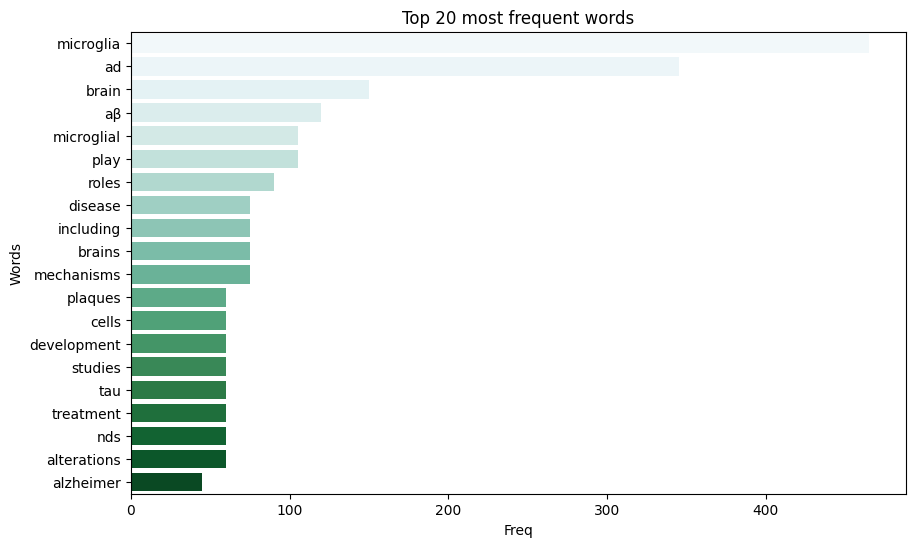

Top 10 found entities:
[('Aβ', 'PERSON'), ('Aβ', 'PERSON'), ('early AD', 'DATE'), ('ND', 'ORG'), ('Aβ', 'PERSON'), ('Aβ', 'PERSON'), ('1', 'CARDINAL'), ('Microglia', 'PERSON'), ('CNS', 'ORG'), ('Molecules 2022', 'PERSON')]


In [30]:
eda = processor.run_eda()

In [31]:
rag_chunks = processor.prepare_chunks()

In [32]:
len(rag_chunks)

150

In [33]:
rag_chunks[8]

Document(metadata={'producer': 'pdfTeX-1.40.21', 'creator': 'LaTeX with hyperref', 'creationdate': '2022-06-28T14:05:32+08:00', 'source': 'molecules-27-04124.pdf', 'file_path': '../data/molecules-27-04124.pdf', 'total_pages': 19, 'format': 'PDF 1.7', 'title': 'Targeting Microglia in Alzheimer’s Disease: From Molecular Mechanisms to Potential Therapeutic Targets for Small Molecules', 'author': 'Ziyad M. Althafar', 'subject': 'Alzheimer’s disease (AD) is a common, progressive, and devastating neurodegenerative disorder that mainly affects the elderly. Microglial dysregulation, amyloid-beta (A) plaques, and intracellular neurofibrillary tangles play crucial roles in the pathogenesis of AD. In the brain, microglia play roles as immune cells to provide protection against virus injuries and diseases. They have significant contributions in the development of the brain, cognition, homeostasis of the brain, and plasticity. Multiple studies have confirmed that uncontrolled microglial function ca

# Реализация RAG-системы

In [34]:
from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

я запускаю локальные модели, которые у меня установлены на пк

In [35]:
model = OllamaLLM(model='llama3.2')
embeddings = OllamaEmbeddings(model='mxbai-embed-large')
db_location = '../chroma_langchain_db'

In [36]:
vector_store = Chroma(
    collection_name='alzheimer_data',
    persist_directory=db_location, 
    embedding_function=embeddings
)

In [37]:
vector_store.add_documents(documents=rag_chunks)

['fd399ed4-29e6-44fa-95af-7ab3acbb969d',
 '67cc5a8a-9dd9-48a9-9e02-a98e077d252c',
 'b71a2325-7357-4175-902b-b7f74e660d76',
 '8d3804de-284b-4671-b9ec-1f40bfcd78b3',
 '43d2c57f-3eb5-448c-b776-c7850e1f451f',
 'e1f6d5be-2b79-4858-83e3-3c238cf44d3b',
 '61f8f95f-63f7-4f1a-a093-34ac05cff4fa',
 '97ffd552-620b-4a4b-98a4-e56018d3fd40',
 '55b2a266-98df-45f1-91c5-97915cd5be09',
 '26df6c94-a121-4911-b69a-f05967632424',
 '890a7c85-0840-4bfd-8de7-8f96016de083',
 '4893a2af-aca4-4d5b-be85-09cbaad1ca70',
 '6c0fa379-32ff-4b09-bf7d-6c8942fea932',
 '0cd5f791-dd30-4db8-951a-573bb99a3694',
 'ac5885aa-fde3-4fcf-94e8-50ec2e32ae3b',
 '9b04ddb1-5a5a-40f5-ac73-4e1a5aa53116',
 '45547b57-56a4-47b5-8d89-f7e48409e636',
 'd2386c4e-e68c-4832-8606-6fd27071bfc7',
 '506e1bf3-eb66-421c-bb39-2af3be5f779c',
 '78db13fe-017d-45d1-ad7b-d56693365a29',
 'ca2e71b1-ab24-476c-8ac2-8f26c67c5f6f',
 'fb429f4e-d4a3-4b74-b68d-ce8c3d350e04',
 '06d3e95e-6b36-4dfb-9393-9a60d87ee07b',
 'a58510e8-2a9d-4054-a8c4-1e62fa891e29',
 'bbc01aec-9fb5-

In [38]:
retriever = vector_store.as_retriever(
    search_kwargs={'k': 5, 'fetch_k': 20},
    search_type='mmr'
)

In [39]:
template = """You are a specialized AI assistant for Alzheimer's disease research.
Use the following pieces of retrieved context to answer the question.
        
Rules:
1. Answer strictly based on the provided context.
2. If the answer is not in the context, say "I don't have enough information in the provided documents."
3. ALWAYS cite the source article names (from metadata) for your statements. Format: [Source: filename.pdf].
4. Focus on drug targets, mechanisms of action, and therapeutic potential.
        
Context:
{context}
        
Question:
{question}
        
Answer:"""

In [40]:
prompt = ChatPromptTemplate.from_template(template)

In [41]:
chain = prompt | model

question = "What are potential targets for Alzheimer's disease treatment?"
docs = retriever.invoke(question)

result = chain.invoke({'context': docs, 'question': question})

In [42]:
print(result)

[Source: filename.pdf]

Although it was initially regarded that microglia reaction is incidental and induced by dystrophic neurites and Aβ plaques. Nonetheless, it has been reported by genome-wide association studies that most of the risk loci for AD are located in genes that are occasionally uniquely and highly expressed in microglia.

This finding further suggests that microglia play significant roles in early AD stages and they can be targeted for the development of novel therapeutics.

Additionally, the article mentions that targeting neuroinflammation is one such downstream target, which is a cause instead of a consequence of neurodegeneration. Mechanisms that are linked with AD pathogenesis are highly complex, but microglia are considered as the key neuroinflammation modulators.

Therefore, potential targets for Alzheimer's disease treatment can be identified in genes that are highly expressed by microglia, such as those involved in neuroinflammation and synaptic function.


In [43]:
question = "Are the targets druggable with small molecules, biologics, or other modalities?"
docs = retriever.invoke(question)

result = chain.invoke({'context': docs, 'question': question})

In [44]:
print(result)

[Source: molecules-27-04124.pdf]

According to the provided context, microglial dysregulation is a key contributor to Alzheimer's disease (AD) pathogenesis. However, the exact mechanisms of how microglia contribute to AD are still not fully revealed.

While the review highlights the importance of targeting microglia for AD treatment, it does not explicitly state whether the targets associated with microglial dysfunction in AD are druggable with small molecules, biologics, or other modalities.


In [45]:
class AlzheimerKnowledgeBase:
    def __init__(self, db_location='../chroma_langchain_db'):
        self.db_location = db_location
        self.model = OllamaLLM(model='llama3.2')
        self.embeddings = OllamaEmbeddings(model='mxbai-embed-large')
        self.vector_store = Chroma(
            collection_name='alzheimer_data',
            persist_directory=self.db_location, 
            embedding_function=self.embeddings
        )
        self.retriever = None

    def index_data(self, data):
        """Функция для преобразования данных в векторы и сохранения их в базе"""
        if not data:
            print('No data to index!')
        else:
            self.vector_store.add_documents(documents=data)

    def get_retriever(self, k=5, fetch_k=20):
        if fetch_k < k:
            print('fetch_k cannot be less than k')
        else:
            self.retriever = self.vector_store.as_retriever(
                search_kwargs={'k': k, 'fetch_k': fetch_k},
                search_type='mmr'
            )
            return self.retriever

    def ask_question(self, question):
        """Функция для получения ответа на вопрос"""
        if not self.retriever:
            self.get_retriever()

        template = """You are a specialized AI assistant for Alzheimer's disease research.
            Use the following pieces of retrieved context to answer the question.
                    
            Rules:
            1. Answer strictly based on the provided context.
            2. If the answer is not in the context, say "I don't have enough information in the provided documents."
            3. ALWAYS cite the source article names (from metadata) for your statements. Format: [Source: filename.pdf].
            4. Focus on drug targets, mechanisms of action, and therapeutic potential.
                    
            Context:
            {context}
                    
            Question:
            {question}
                    
            Answer:
        """
        prompt = ChatPromptTemplate.from_template(template)
        chain = prompt | self.model
        docs = retriever.invoke(question)
        result = chain.invoke({'context': docs, 'question': question})

        return result

In [46]:
kb = AlzheimerKnowledgeBase()

следующая строка закомментирована, тк в базе у меня уже есть данные

In [47]:
# kb.index_data(rag_chunks)

In [48]:
print(kb.ask_question("What are potential targets for Alzheimer's disease treatment?"))

[Source: molecules-27-04124.pdf]

Potential targets for Alzheimer's disease treatment include microglia. Microglial dysregulation, amyloid-beta (A) plaques, and intracellular neurofibrillary tangles play crucial roles in the pathogenesis of AD (1). Genome-wide association studies have identified genes associated with AD risk that are highly expressed by microglia, suggesting that microglia play significant roles in early AD stages and can be targeted for novel therapeutics (1).

References:
(1) Althafar, Z. M. (2022). Targeting Microglia in Alzheimer’s Disease: From Molecular Mechanisms to Potential Therapeutic Targets for Small Molecules. molecules, 27(4), 12424.

Note: The provided context does not specify specific drug targets or mechanisms of action for Alzheimer's disease treatment. However, it highlights the potential for targeting microglia as a therapeutic approach.


Итак, как мы теперь работаем с полученными чанками
1.  Загружаем модели (в моем случае локальные)
2.  Создаем векторную БД Chroma, которая связана с папкой на диске. если она уже есть, то просто подгружаем ее
3.  Загружаем данные в БД *(при необходимости)*
    - метод *index_data* принимает на вход очищенные чанки текста
    - каждый чанк проходит через модель эмбеддингов и превращается в числовой вектор
    - векторы и исходный текст с метаданными хранятся в Chroma
4. Задаем вопрос
    - метод *ask_question* принимает на вход строку с вопросом, которая превращается тоже в вектор
    - ретривер ищет в БД документы, которые максимально близки к вектору вопроса
    - найденные чанки текста и вопрос вставляются в шаблон, который отправляется в модель
    - модель формирует ответ, опираясь на извлеченные данные

## Оценка подхода

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

Для оценки я посмотрела чанки, которые получились, скопировала оттуда текст и скинула нейронке и сказала "придумай вопрос, на который тут можно найти ответ, и напиши сам ответ". Так и получились эти тестовые данные

In [50]:
test_data = [
    {
        "question": "What is the difference between M1 and M2 microglia phenotypes?",
        "ground_truth": "M1 microglia are pro-inflammatory and secrete cytokines like IL-1β, IL-6, and TNF-α, causing neuroinflammation and neuronal death. M2 microglia are anti-inflammatory, mediate neuroprotection, tissue repair, and release growth factors like IGF-1.",
        "source_file": "molecules-27-04124.pdf"
    },
    {
        "question": "What future therapeutic strategies are recommended for developing anti-AD agents?",
        "ground_truth": "Recommended strategies include repositioning/repurposing existing drugs, developing multitarget directed ligands, minimizing toxicity, improving pharmacokinetic profiles, exploring natural products, stem cell therapy, and identifying novel molecular targets.",
        "source_file": "11033_2021_Article_6512.pdf"
    },
    {
        "question": "What is the limitation of the current central hypothesis in Alzheimer's disease regarding amyloid pathology?",
        "ground_truth": "Amyloid pathology does not correlate well with cognitive deficits, and there is a topographical mismatch between amyloid and tau pathology in the early stages of the disease.",
        "source_file": "13195_2024_Article_1504.pdf"
    },
    {
        "question": "What key finding from parabiosis studies in AD mice demonstrates the primary source of elevated myeloid cells in brains with plaque pathology?",
        "ground_truth": "Parabiosis studies in AD mice showed that microglia account for the elevated level of myeloid cells in brains with plaque pathology. These studies also demonstrated the negligible impact of infiltrating macrophages on this elevation.",
        "source_file": "molecules-27-04124.pdf"
    },
    {
        "question": "What do parabiosis studies in AD mice reveal about the source of elevated myeloid cells in brains with plaque pathology and the role of infiltrating macrophages?",
        "ground_truth": "Parabiosis studies in AD mice showed that microglia are responsible for the elevated level of myeloid cells found in brains containing plaque pathology, along with the negligible impact of infiltrating macrophages.",
        "source_file": "nihms-303633.pdf"
    },
    {
        "question": "What are the consequences of tau proteins and Aβ peptide deposits in different brain areas?",
        "ground_truth": "Tau proteins and deposits of Aβ peptides in different brain areas lead to microglial activation, mitochondrial dysfunction, synaptic dysfunction, and even neuronal cell death.",
        "source_file": "ijms-24-00778.pdf"
    },
]

In [51]:
def calculate_hit_rate(retriever, question, target_file, k=5):
    """Функция, которая проверяет, есть ли правильный файл в топ-k найденных документов"""
    retrieved_docs = retriever.invoke(question)
    retrieved_docs = retrieved_docs[:k]
    
    found_sources = [doc.metadata.get('source', '') for doc in retrieved_docs]
    if target_file in found_sources:
        return 1
    return 0

In [52]:
def calculate_semantic_similarity(embedding_model, generated_answer, ground_truth):
    """ 
    Функция, которая превращает сгенерированный ответ и настоящий ответ в векторы и считает их близость.
    1.0 = ответы идентичны по смыслу
    0.0 = ответы абсолютно разные
    """
    vec_gen = embedding_model.embed_query(generated_answer)
    vec_truth = embedding_model.embed_query(ground_truth)
    
    similarity = cosine_similarity([vec_gen], [vec_truth])[0][0]
    return similarity

In [53]:
results = []
for item in test_data:
    q = item['question']
    gt = item['ground_truth']
    src = item['source_file']
    
    # проверяем, удалось ли найти нужную статью
    hit = calculate_hit_rate(kb.retriever, q, src, k=5)

    # генериурем ответ на вопрос
    try:
        generated_answer = kb.ask_question(q)
    except Exception as e:
        print(f"Error generating answer: {e}")
        generated_answer = "Error"

    # сравниваем с эталоном
    sim_score = calculate_semantic_similarity(kb.embeddings, generated_answer, gt)
    
    results.append({
        "question": q,
        "hit_rate": hit,
        "similarity_score": sim_score,
        "generated_answer": generated_answer,
        "ground_truth": gt
    })

In [54]:
df_results = pd.DataFrame(results)
df_results

,question,hit_rate,similarity_score,generated_answer,ground_truth
0,What is the difference between M1 and M2 micro...,1,0.904836,[Source: molecules-27-04124.pdf]\nAccording to...,M1 microglia are pro-inflammatory and secrete ...
1,What future therapeutic strategies are recomme...,1,0.623341,[Source: molecules-27-04124.pdf]\n\nAccording ...,Recommended strategies include repositioning/r...
2,What is the limitation of the current central ...,0,0.688039,I don't have enough information in the provide...,Amyloid pathology does not correlate well with...
3,What key finding from parabiosis studies in AD...,1,0.957764,[Source: nihms-594059.pdf]\n\nParabiosis studi...,Parabiosis studies in AD mice showed that micr...
4,What do parabiosis studies in AD mice reveal a...,1,0.933770,[Source: molecules-27-04124.pdf]\n\nParabiosis...,Parabiosis studies in AD mice showed that micr...
5,What are the consequences of tau proteins and ...,0,0.919290,According to the provided context from [Source...,Tau proteins and deposits of Aβ peptides in di...


In [55]:
print(f"Mean hit rate: {df_results['hit_rate'].mean():.2f}")
print(f"Mean similatiry: {df_results['similarity_score'].mean():.2f}")

Mean hit rate: 0.67
Mean similatiry: 0.84


В 67% случаев модель обращалась к тому же файлу, что и указан в тестовых данных и в большинстве случаев ответ модели близок к эталонному ответу. Можем сделать вывод, что модель корректно интерпретирует контекст и, судя по результатам, на один из вопросов ответ она не нашла, а на другой, возможно, нашла ответ в другом файле

**Выводы про проделанной работе:**
1. Был собран небольшой датасет из бесплатных научных статей. Из статей были извлечены и очищены абстракты, введения и заключения, на выходе мы получили красивый небольшой текст без лишнего шума
2. Данные были разделены на чанки и векторизованы, чтобы модель могла их прочитать и выдавать более точные ответы
3. Текущая реализация показала себя довольно хорошо, но пока что работает локально

# Реализация интерфейса

код для интерфейса находится в файле *'app.py'*

# Вопросы

**1. На какие модальности данных можно расширить решение?**
   
   Сейчас решение работает только с текстами. Можно расширить до мультимодальной системы и добавить следующие модальности:
   - изображения (МРТ, КТ, ПЭТ)
   - табличные данные (клинические показатели пациентов, результаты клинических испытаний)
   - временные ряды (лонгитюдные клинические наблюдения)

   Примеры вопросов, которые можно будет задать при наличии таких модальностей:
   - Какие паттерны атрофии мозга соответствуют соответствуют ранней стадии развития альцгеймера?
   - Отличаются ли биомаркеры у пациентов с разной скоростью прогрессии?
   - Как быстро ухудшается когнитивная функция на разных стадиях?
     
**2. Как это можно сделать?**
   
   - Для изображений использовать image encoders, эмбеддинги хранить можно либо в общей векторной бд, либо в другой
   - Табличные данные сериализровать в текст или использовать отдельный tabular encoder и переводить в векторы
   - Можно аггрерировать ряд (например, тренд растет/падает, точки перелома) и превратить его в структурированный текст, который кодируется теми же эмбеддингами. Или можно использовать специальный TS encoder и переводить в векторы
     
**3. Какие модели и почему вы выбрали для решения?**
   - LLM: llama3.2. Небольшая, что позволяет запустить решение локально, из чего следует воспроизводимость решения. Эта модель балансирует между производительностью и скоростью генерации текста. Ну и выдает адекватные ответы)
   - Embeddings: mxbai-embed-large. Эмбеддинги бинарные, это позволяет сэкономить место в памяти. Довольно быстро находит нужные данные. Обеспечивает высокую обобщающую способность на различные области